In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim import Adam
from skimage import io, transform
from torch import optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
import albumentations as A
from torchvision import transforms as T
import os
from PIL import Image
from glob import glob

torch.manual_seed(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 24
Img_size = 256
pin_memory = True
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

def Otsu(img):
  mean = img.mean()
  img[img < mean] = 0
  img[img > mean] = 1
  return img

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((Img_size, Img_size)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = T.Compose(
    [T.ToTensor(),
     T.Resize((Img_size, Img_size)),
    #   T.Normalize(mean = [0.485, 0.456, 0.406] ,std = [0.229, 0.224, 0.225]),
    #  T.RandomRotation(45),
    #  T.RandomHorizontalFlip(0.5),
    #  T.ColorJitter(),
     ])

class Testdata(Dataset):
    def __init__(self, directory, transform):
      self.files = glob(directory)
      self.transform = transform
      self.dir = directory
    def __len__(self):
      return len(self.files)
    def __getitem__(self, index):
      file = self.files[index]
      img = Image.open(os.path.join(self.dir, file)).convert('RGB')
      img = self.transform(img)
      return img, file

test_ds = Testdata("/kaggle/input/sctl-reasearch/Test/Test/*.jpg", transform = test_transforms)
test_loader = DataLoader(test_ds, pin_memory=pin_memory)

# Original dataset
full_dataset = ImageFolder(r"/kaggle/input/sctl-reasearch/Train/Train/", transform = train_transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_ds, valid_ds = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)

# New dataset with Diffusion images
full_dataset_SD = ImageFolder(r"/kaggle/input/sctl-sd/SCTL SD/Train", transform = train_transforms)
train_size = int(0.8 * len(full_dataset_SD))
test_size = len(full_dataset_SD) - train_size
train_ds_SD, valid_ds_SD = torch.utils.data.random_split(full_dataset_SD, [train_size, test_size])

train_loader_SD = DataLoader(train_ds_SD, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
valid_loader_SD = DataLoader(valid_ds_SD, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)

print(f"Original dataset Train size {len(train_ds)} valid size {len(valid_ds)}")
print(f"SD dataset Train size {len(train_ds_SD)} valid size {len(valid_ds_SD)}")

Original dataset Train size 919 valid size 230
SD dataset Train size 1571 valid size 393


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([24, 3, 256, 256]) torch.Size([24])
1


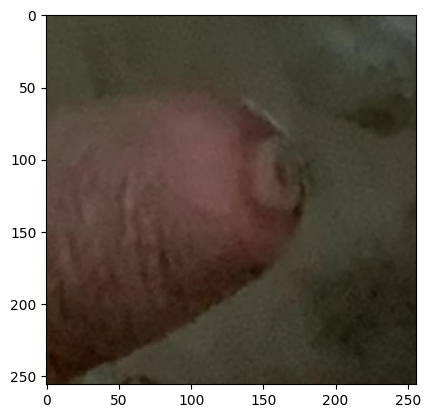

In [3]:
for img, lbl in train_loader_SD:
    print(img.shape, lbl.shape)
    break
print(lbl[0].item())
plt.imshow(img[0].detach().cpu().swapaxes(0, 2))

# Utility functions

[0.25 0.25 0.25 0.25]


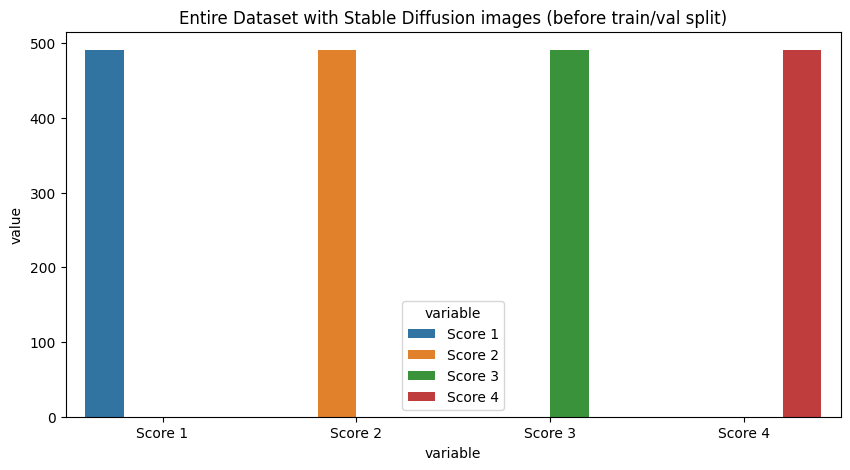

In [5]:
idx2class = {v: k for k, v in full_dataset_SD.class_to_idx.items()}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable").set_title(plot_title)
plt.figure(figsize=(10,5))
class_dist = get_class_distribution(full_dataset_SD)
plot_from_dict(class_dist, plot_title="Entire Dataset with Stable Diffusion images (before train/val split)")

# Inverse class weights
# inverse_cls_dist = 1 - np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset_SD)
print(np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset_SD))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0.3916449  0.4273281  0.16275021 0.01827676]


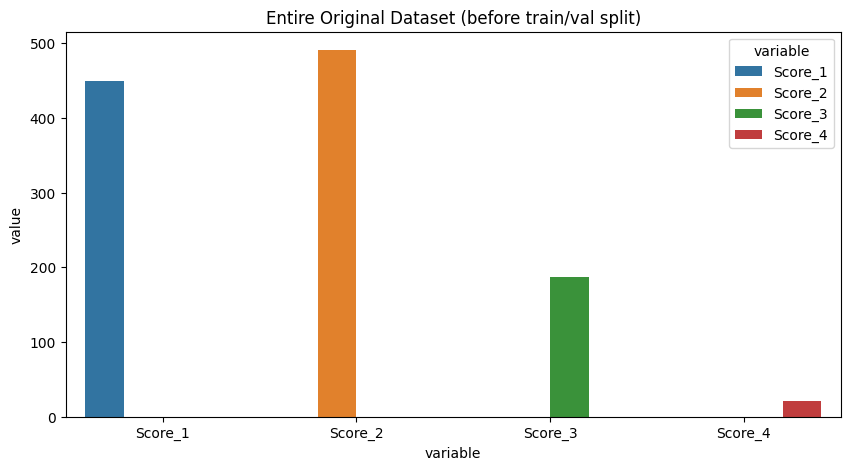

In [6]:
idx2class = {v: k for k, v in full_dataset.class_to_idx.items()}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable").set_title(plot_title)
plt.figure(figsize=(10,5))
class_dist = get_class_distribution(full_dataset)
plot_from_dict(class_dist, plot_title="Entire Original Dataset (before train/val split)")

# Inverse class weights
inverse_cls_dist = 1 - np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset)
print(np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset))

In [7]:
def get_best_model(model, is_SD = True):
    model_name = model.__class__.__name__
    if is_SD:
      model_name+="_SD"
    else:
      model_name += "_Org"
    models = []
    accs = []
    for f in os.listdir():
        if model_name in f and f.endswith(".pth"):
            models.append(f)
            acc = f.split("_")[2].split(".")[1]
            accs.append(acc)
    model = torch.load(models.pop(np.argmax(accs)))
    for i in models:
        os.remove(i)
    return model

# vit_best = get_best_model(vit)

In [8]:
def test_model(model, is_SD=True):
  model_n = model.__class__.__name__
  if is_SD:
    model_n += "_SD"
  else:
    model_n += "_Org"
  test_preds = []
  files = []

  with torch.no_grad():
      
      for batch in test_loader:
          img, fname = batch
          pred = model(img.to(device))
          test_preds.extend(torch.argmax(pred, dim=1).detach().cpu())
          files.extend(np.array(fname).flatten())
          
  df = pd.DataFrame({"Imagename":files, "preds":test_preds})
  df.preds = df.preds.astype(int)
  df.Imagename = df.Imagename.apply(lambda x: x.split("/")[-1])
  df.to_csv(model_n+"_submission.csv", header=None, index=None)
  print("Submission file created!")

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss

        if self.alpha is not None:
            alpha = self.alpha[targets]
            focal_loss = alpha * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss


# Initializing parameters

In [10]:
num_epochs = 30
accuracies = {}
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
ce_loss   = nn.CrossEntropyLoss()
F_loss = FocalLoss()
# trainSteps = int(len(train_ds)/batch_size)
# testSteps = int(len(valid_ds)/batch_size)

# Defining training loop

In [11]:
def train_model(model, traindl, testdl, loss_fn, epochs, learning_rate, is_SD=True):
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    train_acc = []

    opt = optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = loss_fn
    model = model.to(device)
    model_name = model.__class__.__name__
    if is_SD:
      trainSteps = int(len(train_ds_SD)/batch_size)
      validSteps = int(len(valid_ds_SD)/batch_size)
      model_name += "_SD"
    else:
      trainSteps = int(len(train_ds)/batch_size)
      validSteps = int(len(valid_ds)/batch_size)
      model_name += "_Org"
    best_val_loss = float('inf')

    try:
        for epoch in range(1, epochs+1):
            # Training loop
            model.train(True)
            correct = 0
            totalTrainLoss ,totalTestLoss, totalTrainAcc, totalTestAcc = 0, 0, 0, 0

            for X, y in tqdm(traindl):  
                X, y = X.to(device), y.to(device) 
                opt.zero_grad()
                yhat = model(X) 
                # loss = (1- iou(y, yhat))
        #         loss = loss_fn(y, yhat) * 0.4 + (1-iou(y, yhat))*0.6
                loss = loss_fn(yhat, y)
                acc = (torch.argmax(yhat, axis=1) == y).sum()/batch_size
                totalTrainAcc += acc.item()
                totalTrainLoss += loss.item()
                loss.backward()
                opt.step() 
            avg_acc = totalTrainAcc / trainSteps
            avg_loss = (totalTrainLoss/trainSteps)
            train_acc.append(avg_acc)
            train_loss.append(avg_loss)

            # Evaluation step
            model.train(False)

            with torch.no_grad():
                for X, y in tqdm(testdl): 
                    X, y = X.to(device), y.to(device) 
                    yhat = model(X) 
                    loss = loss_fn(yhat, y)
                    acc = (y == torch.argmax(yhat, axis=1)).sum()/batch_size
                    totalTestAcc += acc.item()
                    totalTestLoss += loss.item()
                avg_acc = (totalTestAcc/validSteps)
                avg_loss = (totalTestLoss/validSteps)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    torch.save(model, f"{model_name}_{round(avg_acc, 5)}.pth")
                valid_loss.append(avg_loss)
                valid_acc.append(avg_acc)
                print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
             valid loss: {avg_loss} valid accuracy: {avg_acc} ")

    except KeyboardInterrupt:
        return model, train_loss, valid_loss, train_acc, valid_acc
    return model, train_loss, valid_loss, train_acc, valid_acc

# VGG 19

In [27]:
class VGG19(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential( 
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(3, stride=2),
            # nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            # nn.LeakyReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(512*3*3, 5000),
            nn.ReLU(),
            nn.Linear(5000, 500),
            nn.ReLU(),
            nn.Linear(500, 4),
            # nn.Sigmoid()
     )
    def forward(self, img):
        return self.model(img)


In [52]:
vgg19 = VGG19()
vgg19, train_loss, valid_loss, train_acc, valid_acc = train_model(vgg19, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["VGG19 Original"] = max(valid_acc)

100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch:1 train loss: 214484.2893550694              valid loss: 6873.593234592014 valid accuracy: 0.4074074212047789 


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Epoch:2 train loss: 1163494.8976087067              valid loss: 1286498.1805555555 valid accuracy: 0.39814815587467617 


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Epoch:3 train loss: 130017039.94407895              valid loss: 46001926.222222224 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch:4 train loss: 15828996787.68421              valid loss: 55760885987.55556 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Epoch:5 train loss: 84106455364.09987              valid loss: 0.8500435418552823 valid accuracy: 0.4074074212047789 


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Epoch:6 train loss: 0.7767503622331118              valid loss: 0.8294292754597135 valid accuracy: 0.4074074261718326 


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch:7 train loss: 0.7603550459209242              valid loss: 0.8104060888290405 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch:8 train loss: 0.744263481152685              valid loss: 0.7949954205089145 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Epoch:9 train loss: 0.730587827531915              valid loss: 0.776689608891805 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Epoch:10 train loss: 0.7167809731081912              valid loss: 0.7623812821176317 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch:11 train loss: 0.7056433370238856              valid loss: 0.7506091992060343 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Epoch:12 train loss: 0.6945625276942002              valid loss: 0.7368829051653544 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch:13 train loss: 0.6844399085170344              valid loss: 0.7234200769000583 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch:14 train loss: 0.6736700581876855              valid loss: 0.7107678121990628 valid accuracy: 0.40740741623772514 


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch:15 train loss: 0.6657916401561937              valid loss: 0.7021269732051425 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Epoch:16 train loss: 0.6568472683429718              valid loss: 0.689513795905643 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch:17 train loss: 0.6514009896077608              valid loss: 0.6816436118549771 valid accuracy: 0.4074074195490943 


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch:18 train loss: 0.6426438610804709              valid loss: 0.6746702790260315 valid accuracy: 0.49074075950516594 


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch:19 train loss: 0.636377071079455              valid loss: 0.666934159066942 valid accuracy: 0.4907407561937968 


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch:20 train loss: 0.6339525643147921              valid loss: 0.6627293626467387 valid accuracy: 0.49074075950516594 


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch:21 train loss: 0.6300204804069117              valid loss: 0.6520555946562026 valid accuracy: 0.49074075950516594 


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch:22 train loss: 0.6229850367495888              valid loss: 0.6492772897084554 valid accuracy: 0.49074075784948135 


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch:23 train loss: 0.6185040850388376              valid loss: 0.6405305928654141 valid accuracy: 0.4907407561937968 


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch:24 train loss: 0.6118949683089006              valid loss: 0.636676914162106 valid accuracy: 0.49074075288242763 


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Epoch:25 train loss: 0.6135229060524389              valid loss: 0.6301033827993605 valid accuracy: 0.49074075288242763 


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch:26 train loss: 0.6056717571459318              valid loss: 0.6308471858501434 valid accuracy: 0.49074075288242763 


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Epoch:27 train loss: 0.6037567830399463              valid loss: 0.62128084897995 valid accuracy: 0.49074074625968933 


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Epoch:28 train loss: 0.5993849501798028              valid loss: 0.6232735448413425 valid accuracy: 0.4907407611608505 


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch:29 train loss: 0.5950775499406614              valid loss: 0.6153427561124166 valid accuracy: 0.4907407561937968 


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Epoch:30 train loss: 0.593711931454508              valid loss: 0.6117813189824423 valid accuracy: 0.49074075288242763 


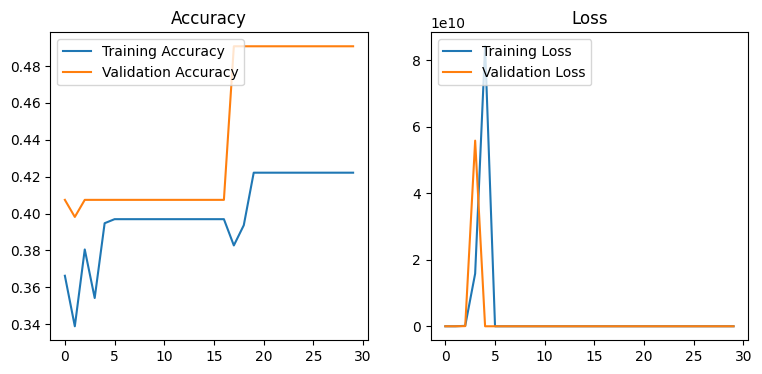

In [53]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [54]:
best_vgg19 = get_best_model(vgg19, is_SD=False) # Testing the best VGG 19 model
test_model(best_vgg19, is_SD=False)

Submission file created!


## Augmented dataset

In [67]:
vgg19 = VGG19() # ReInitializing the model weigths

vgg19, train_loss, valid_loss, train_acc, valid_acc = train_model(vgg19, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["VGG19 SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch:1 train loss: 3544719.9468460907              valid loss: 52755591.875 valid accuracy: 0.24479167396202683 


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch:2 train loss: 6091618.907001202              valid loss: 32961.40588378906 valid accuracy: 0.39322917675599456 


100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch:3 train loss: 6086.264102877103              valid loss: 1191.7463054656982 valid accuracy: 0.48958334513008595 


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch:4 train loss: 928.1473966158353              valid loss: 654.6642999649048 valid accuracy: 0.6093750111758709 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:5 train loss: 606.1428126408504              valid loss: 484.6004943847656 valid accuracy: 0.6302083535119891 


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch:6 train loss: 499.1523111196665              valid loss: 433.126380443573 valid accuracy: 0.5755208395421505 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:7 train loss: 364.68344791118915              valid loss: 349.2108242511749 valid accuracy: 0.6041666883975267 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:8 train loss: 335.30995412973255              valid loss: 305.927481174469 valid accuracy: 0.6041666865348816 


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch:9 train loss: 272.4937287550706              valid loss: 377.4283199310303 valid accuracy: 0.5625000204890966 


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch:10 train loss: 267.56092037787806              valid loss: 203.75990343093872 valid accuracy: 0.619791679084301 


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch:11 train loss: 227.55642879192646              valid loss: 170.09810638427734 valid accuracy: 0.5963541902601719 


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Epoch:12 train loss: 186.21430159348708              valid loss: 166.1425542831421 valid accuracy: 0.5520833507180214 


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch:13 train loss: 138.57280625563402              valid loss: 184.60103511810303 valid accuracy: 0.5130208404734731 


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch:14 train loss: 103.91117748847374              valid loss: 100.19239282608032 valid accuracy: 0.6250000167638063 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:15 train loss: 93.61016135582557              valid loss: 84.99300873279572 valid accuracy: 0.6614583563059568 


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch:16 train loss: 105.4463305253249              valid loss: 125.82878112792969 valid accuracy: 0.486979179084301 


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch:17 train loss: 72.95434997265156              valid loss: 74.46595013141632 valid accuracy: 0.6406250223517418 


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch:18 train loss: 68.16665556981013              valid loss: 68.7619366645813 valid accuracy: 0.6041666883975267 


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch:19 train loss: 53.73293528923622              valid loss: 57.124588906764984 valid accuracy: 0.6875000242143869 


100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch:20 train loss: 64.3771681712224              valid loss: 118.66587972640991 valid accuracy: 0.559895851649344 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:21 train loss: 101.05519862541786              valid loss: 85.85438352823257 valid accuracy: 0.7083333507180214 


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch:22 train loss: 66.24205385354848              valid loss: 52.22282496094704 valid accuracy: 0.6640625279396772 


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch:23 train loss: 47.22696900000939              valid loss: 60.30769968032837 valid accuracy: 0.5234375176951289 


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


Epoch:24 train loss: 38.70441210086529              valid loss: 58.89489960670471 valid accuracy: 0.6328125204890966 


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch:25 train loss: 38.02374622638409              valid loss: 113.95615863800049 valid accuracy: 0.4895833460614085 


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch:26 train loss: 50.63876819243798              valid loss: 48.50806427001953 valid accuracy: 0.6666666911914945 


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch:27 train loss: 29.938986213390645              valid loss: 34.951807379722595 valid accuracy: 0.6718750223517418 


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch:28 train loss: 44.51790570479173              valid loss: 53.1159348487854 valid accuracy: 0.5781250186264515 


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch:29 train loss: 38.51445082884568              valid loss: 36.696463882923126 valid accuracy: 0.627604179084301 


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]

Epoch:30 train loss: 31.768038170154277              valid loss: 49.4797457754612 valid accuracy: 0.5963541818782687 


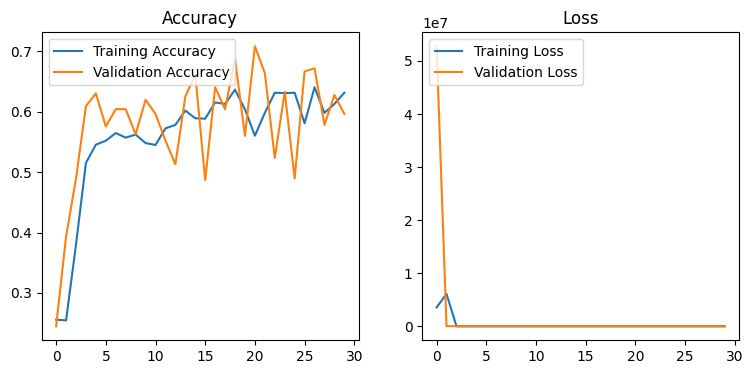

In [68]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [69]:
best_vgg19 = get_best_model(vgg19) # Testing the best VGG 19 model
test_model(best_vgg19)

Submission file created!


# Custom model

In [55]:
class TeatClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 16, kernel_size = 5, stride=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(), 
            nn.Conv2d(in_channels=16, out_channels = 32, kernel_size = 5, stride=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(), 
            nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 5, stride=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64*2*2, 1000), 
            nn.LeakyReLU(),
            nn.Linear(1000, 4)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
teatclf = TeatClassifier()
teatclf, train_loss, valid_loss, train_acc, valid_acc = train_model(teatclf, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["Teat Clf Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch:1 train loss: 0.5644417777657509              valid loss: 0.6833524372842577 valid accuracy: 0.49537038968669045 


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch:2 train loss: 0.43583578812448603              valid loss: 0.9051651292377048 valid accuracy: 0.31018519070413375 


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch:3 train loss: 0.417323027002184              valid loss: 0.5170931617418925 valid accuracy: 0.6296296450826857 


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch:4 train loss: 0.4004908502101898              valid loss: 0.5824360648790995 valid accuracy: 0.45370371805297005 


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch:5 train loss: 0.4163478663877437              valid loss: 0.46213481492466396 valid accuracy: 0.625000023179584 


100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Epoch:6 train loss: 0.4080747742401926              valid loss: 0.6336592270268334 valid accuracy: 0.5046296450826857 


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch:7 train loss: 0.3898134384500353              valid loss: 0.5436176492108239 valid accuracy: 0.5555555721124014 


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch:8 train loss: 0.3886190009744544              valid loss: 0.49996405177646214 valid accuracy: 0.6018518673049079 


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch:9 train loss: 0.37608449945324346              valid loss: 0.7649304668108622 valid accuracy: 0.5000000066227384 


100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Epoch:10 train loss: 0.3774998415457575              valid loss: 0.6487609810299344 valid accuracy: 0.40740741789340973 


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch:11 train loss: 0.35853674968606547              valid loss: 0.47244307729933 valid accuracy: 0.5879629817273881 


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch:12 train loss: 0.37319082884412064              valid loss: 0.4619015587700738 valid accuracy: 0.6388889054457346 


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch:13 train loss: 0.37898182986598267              valid loss: 0.4546789990531074 valid accuracy: 0.6666666865348816 


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Epoch:14 train loss: 0.3581108623429349              valid loss: 0.4867354796992408 valid accuracy: 0.6527777910232544 


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Epoch:15 train loss: 0.3555792530900554              valid loss: 0.4938443766699897 valid accuracy: 0.5416666865348816 


100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Epoch:16 train loss: 0.3567466026074008              valid loss: 0.4692566461033291 valid accuracy: 0.6296296417713165 


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Epoch:17 train loss: 0.33337500181637314              valid loss: 0.5640099942684174 valid accuracy: 0.5972222420904372 


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


Epoch:18 train loss: 0.33259265203224986              valid loss: 0.520226788189676 valid accuracy: 0.5277778009573618 


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch:19 train loss: 0.32421812415122986              valid loss: 0.4219358397854699 valid accuracy: 0.6342592835426331 


100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Epoch:20 train loss: 0.32191847892184006              valid loss: 0.4478643172317081 valid accuracy: 0.6250000264909532 


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch:21 train loss: 0.30598575386561844              valid loss: 0.5261570513248444 valid accuracy: 0.5879629817273881 


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch:22 train loss: 0.30615825049187007              valid loss: 0.4014507813586129 valid accuracy: 0.6296296417713165 


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Epoch:23 train loss: 0.29414364930830506              valid loss: 0.4337701035870446 valid accuracy: 0.6481481724315219 


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch:24 train loss: 0.30522386180727107              valid loss: 0.5393145415518019 valid accuracy: 0.5740740928384993 


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


Epoch:25 train loss: 0.2951138713642171              valid loss: 0.39322391814655727 valid accuracy: 0.6620370613204108 


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch:26 train loss: 0.3078194723317498              valid loss: 0.44409871101379395 valid accuracy: 0.6435185472170512 


  0%|          | 0/10 [00:00<?, ?it/s]

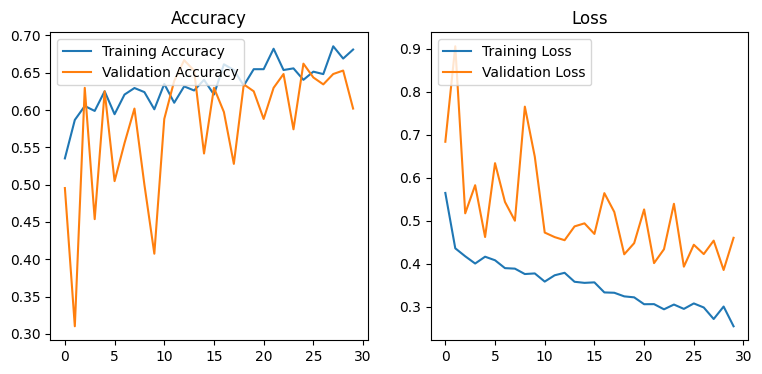

In [59]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [60]:
best_teatclf = get_best_model(teatclf, is_SD=False) # Testing the best VGG 19 model
test_model(best_teatclf, is_SD=False)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Submission file created!


## Augmented dataset

In [71]:
teatclf = TeatClassifier() # ReInitializing the model weigths

teatclf, train_loss, valid_loss, train_acc, valid_acc = train_model(teatclf, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["Teat CLF SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch:1 train loss: 0.9872583430546981              valid loss: 0.7468664012849331 valid accuracy: 0.7057291902601719 


100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Epoch:2 train loss: 0.6924602508544921              valid loss: 0.6726029124110937 valid accuracy: 0.7369791865348816 


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch:3 train loss: 0.6424009735767658              valid loss: 0.7295939717441797 valid accuracy: 0.7473958507180214 


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch:4 train loss: 0.5928899875053992              valid loss: 0.6061776056885719 valid accuracy: 0.7500000167638063 


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch:5 train loss: 0.6118002323003916              valid loss: 0.575880111195147 valid accuracy: 0.7656250260770321 


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch:6 train loss: 0.5776995590099921              valid loss: 0.5636311192065477 valid accuracy: 0.7968750186264515 


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch:7 train loss: 0.5664520181142367              valid loss: 0.6358890226110816 valid accuracy: 0.7473958544433117 


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch:8 train loss: 0.5513346497829144              valid loss: 0.5704024285078049 valid accuracy: 0.776041692122817 


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch:9 train loss: 0.5444367578396431              valid loss: 0.5132128745317459 valid accuracy: 0.8229166883975267 


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch:10 train loss: 0.520498820910087              valid loss: 0.7878428064286709 valid accuracy: 0.7291666865348816 


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch:11 train loss: 0.5299833325239328              valid loss: 0.5133245354518294 valid accuracy: 0.8020833525806665 


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch:12 train loss: 0.504055480315135              valid loss: 0.6192674823105335 valid accuracy: 0.7630208488553762 


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch:13 train loss: 0.4828147842333867              valid loss: 0.5194222582504153 valid accuracy: 0.8125000223517418 


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch:14 train loss: 0.5156346447192706              valid loss: 0.5400830544531345 valid accuracy: 0.7890625111758709 


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch:15 train loss: 0.49469643693703874              valid loss: 0.5630974918603897 valid accuracy: 0.8020833507180214 


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch:16 train loss: 0.49962033606492556              valid loss: 0.5167038440704346 valid accuracy: 0.8151041828095913 


100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Epoch:17 train loss: 0.47346809368867143              valid loss: 0.5187994949519634 valid accuracy: 0.807291692122817 


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch:18 train loss: 0.5004796707859406              valid loss: 0.5049576889723539 valid accuracy: 0.8359375223517418 


100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Epoch:19 train loss: 0.4651677785011438              valid loss: 0.533321077004075 valid accuracy: 0.7864583469927311 


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch:20 train loss: 0.44957762819070085              valid loss: 0.5843341182917356 valid accuracy: 0.8255208507180214 


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch:21 train loss: 0.47614910900592805              valid loss: 0.7709788242354989 valid accuracy: 0.7473958563059568 


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch:22 train loss: 0.44801467244441695              valid loss: 0.5381104294210672 valid accuracy: 0.8020833469927311 


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch:23 train loss: 0.4389245074528914              valid loss: 0.5686965752393007 valid accuracy: 0.7968750223517418 


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch:24 train loss: 0.45003517293013057              valid loss: 0.5242711389437318 valid accuracy: 0.8203125223517418 


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch:25 train loss: 0.41545474941913896              valid loss: 0.5292335841804743 valid accuracy: 0.7916666883975267 


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch:26 train loss: 0.42399173470643853              valid loss: 0.5522666880860925 valid accuracy: 0.8229166865348816 


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch:27 train loss: 0.4218689975830225              valid loss: 0.5997611721977592 valid accuracy: 0.7760416865348816 


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch:28 train loss: 0.43700831005206475              valid loss: 0.5207626055926085 valid accuracy: 0.8020833507180214 


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch:29 train loss: 0.4181854291604115              valid loss: 0.5846739634871483 valid accuracy: 0.7890625260770321 


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]

Epoch:30 train loss: 0.41257262321618887              valid loss: 0.5005952389910817 valid accuracy: 0.8125000260770321 


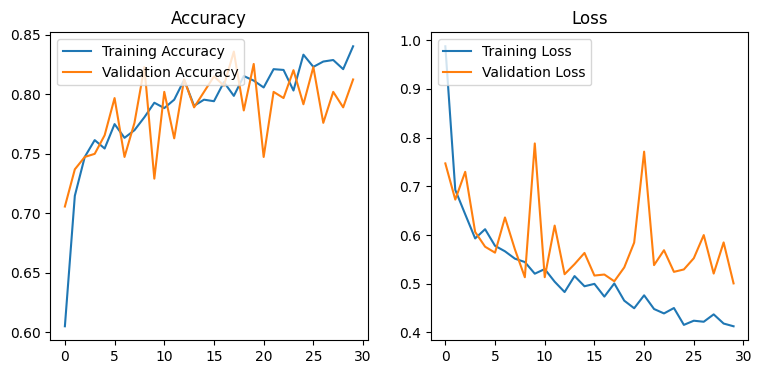

In [72]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [73]:
best_teatclf = get_best_model(teatclf ) # Testing the best VGG 19 model
test_model(best_teatclf)

Submission file created!


In [80]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129}

# ResNet 18 and 50

In [75]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        ) if stride != 1 or in_channels != out_channels * self.expansion else None

    def forward(self, x):
        identity = x
        out = self.layers(x)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 64, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(8 * 8, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        return nn.Sequential(
            block(self.in_channels, out_channels, stride=stride),
            *[block(out_channels * block.expansion, out_channels) for _ in range(1, blocks)]
        )

    def forward(self, x):
        x = self.layers(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [77]:
resnet18 = ResNet18(BasicBlock, [2, 2, 2, 2])
resnet18, train_loss, valid_loss, train_acc, valid_acc = train_model(resnet18, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["ResNet18 Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch:1 train loss: 0.5089154565020612              valid loss: 0.6194617549578348 valid accuracy: 0.5509259435865614 


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch:2 train loss: 0.4312590933159778              valid loss: 0.45494311054547626 valid accuracy: 0.6435185405943129 


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch:3 train loss: 0.4194436575237073              valid loss: 0.5549793905682034 valid accuracy: 0.5370370580090417 


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch:4 train loss: 0.4147650160287556              valid loss: 0.45587581396102905 valid accuracy: 0.6203703880310059 


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch:5 train loss: 0.40700360701272364              valid loss: 0.8541335463523865 valid accuracy: 0.5509259502092997 


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch:6 train loss: 0.4132779370013036              valid loss: 0.6156259477138519 valid accuracy: 0.5138888988229964 


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch:7 train loss: 0.3975966219839297              valid loss: 0.45126155349943375 valid accuracy: 0.6296296450826857 


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch:8 train loss: 0.39724511574757726              valid loss: 0.45827676521407235 valid accuracy: 0.6296296417713165 


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch:9 train loss: 0.39533582957167374              valid loss: 0.5779020388921102 valid accuracy: 0.5462963084379832 


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch:10 train loss: 0.38692998807681234              valid loss: 0.549069325129191 valid accuracy: 0.6111111243565878 


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch:11 train loss: 0.37060512955251496              valid loss: 0.48101645045810276 valid accuracy: 0.6296296417713165 


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch:12 train loss: 0.3837110337458159              valid loss: 0.503547168440289 valid accuracy: 0.5833333532015482 


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch:13 train loss: 0.36574103016602366              valid loss: 0.4622567858960893 valid accuracy: 0.6388889087571038 


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch:14 train loss: 0.3678797303061736              valid loss: 0.5132520496845245 valid accuracy: 0.6342592736085256 


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch:15 train loss: 0.36364268315465825              valid loss: 0.6509223547246721 valid accuracy: 0.5416666832235124 


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch:16 train loss: 0.3673041474662329              valid loss: 0.548344482978185 valid accuracy: 0.5925926102532281 


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch:17 train loss: 0.35844988964105906              valid loss: 0.5214230269193649 valid accuracy: 0.6018518639935387 


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch:18 train loss: 0.3734426121962698              valid loss: 0.530767516957389 valid accuracy: 0.5601852072609795 


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch:19 train loss: 0.35045494374475983              valid loss: 0.47667373220125836 valid accuracy: 0.6157407661279043 


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


Epoch:20 train loss: 0.36171639083247437              valid loss: 0.4885024395253923 valid accuracy: 0.6157407595051659 


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch:21 train loss: 0.34671240378367274              valid loss: 0.6064757042460971 valid accuracy: 0.6388889087571038 


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch:22 train loss: 0.34475477471163396              valid loss: 0.5102392534414927 valid accuracy: 0.6018518673049079 


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch:23 train loss: 0.35162914348276036              valid loss: 0.4857663545343611 valid accuracy: 0.5925926102532281 


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch:24 train loss: 0.34744997479413686              valid loss: 0.4403714140256246 valid accuracy: 0.5833333432674408 


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch:25 train loss: 0.3230797620980363              valid loss: 0.46182503799597424 valid accuracy: 0.620370391342375 


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch:26 train loss: 0.3327284310209124              valid loss: 0.4746033267842399 valid accuracy: 0.5231481724315219 


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Epoch:27 train loss: 0.3401142013700385              valid loss: 0.512566950586107 valid accuracy: 0.5694444643126594 


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch:28 train loss: 0.3425584137439728              valid loss: 0.516744260986646 valid accuracy: 0.6157407661279043 


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch:29 train loss: 0.31489274886093643              valid loss: 0.4593464169237349 valid accuracy: 0.5925926102532281 


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]

Epoch:30 train loss: 0.3036407518543695              valid loss: 0.465209037065506 valid accuracy: 0.6157407495710585 


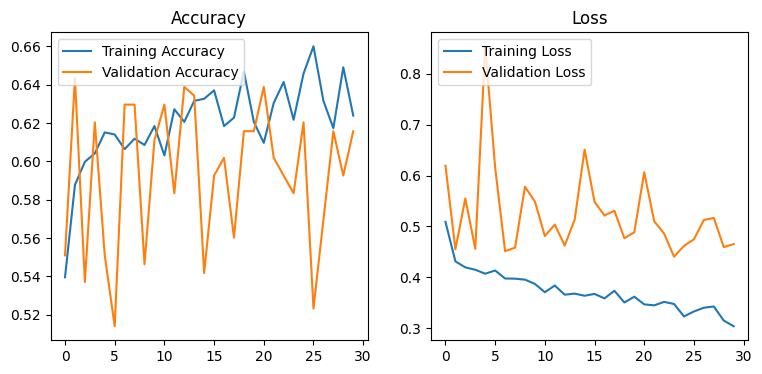

In [78]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [79]:
best_resnet18 = get_best_model(resnet18, is_SD=False) # Testing the best VGG 19 model
test_model(best_resnet18, is_SD=False)

Submission file created!


## Augmented dataset

In [81]:
resnet18 = ResNet18(BasicBlock, [2, 2, 2, 2]) # ReInitializing the model weigths

resnet18, train_loss, valid_loss, train_acc, valid_acc = train_model(resnet18, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["ResNet18 SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch:1 train loss: 0.8731602283624502              valid loss: 0.8005625382065773 valid accuracy: 0.7109375149011612 


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch:2 train loss: 0.678146342589305              valid loss: 1.0222056470811367 valid accuracy: 0.5859375167638063 


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch:3 train loss: 0.6450127821702224              valid loss: 0.6225382182747126 valid accuracy: 0.7838541883975267 


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch:4 train loss: 0.608108632839643              valid loss: 0.8943527936935425 valid accuracy: 0.7109375186264515 


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch:5 train loss: 0.6057754012254568              valid loss: 3.0315648168325424 valid accuracy: 0.3854166753590107 


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch:6 train loss: 0.5873997122049331              valid loss: 1.4767003692686558 valid accuracy: 0.5989583525806665 


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch:7 train loss: 0.5895702215341422              valid loss: 0.6174497734755278 valid accuracy: 0.7812500204890966 


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch:8 train loss: 0.5743321872674502              valid loss: 0.5821544863283634 valid accuracy: 0.7526041846722364 


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch:9 train loss: 0.5430410222365306              valid loss: 0.6041068024933338 valid accuracy: 0.7812500204890966 


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch:10 train loss: 0.5441751759785872              valid loss: 0.5794196501374245 valid accuracy: 0.8046875260770321 


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch:11 train loss: 0.5076986101957468              valid loss: 0.5541333984583616 valid accuracy: 0.8177083469927311 


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch:12 train loss: 0.530576505110814              valid loss: 1.4189383387565613 valid accuracy: 0.583333351649344 


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch:13 train loss: 0.5090589738809146              valid loss: 0.6218989677727222 valid accuracy: 0.7838541846722364 


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch:14 train loss: 0.5029076447853675              valid loss: 0.6110018789768219 valid accuracy: 0.7890625223517418 


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch:15 train loss: 0.49222014706868394              valid loss: 0.6344938669353724 valid accuracy: 0.7760416865348816 


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch:16 train loss: 0.5034356254797715              valid loss: 0.5603486746549606 valid accuracy: 0.7786458544433117 


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch:17 train loss: 0.4931850818487314              valid loss: 0.7534328754991293 valid accuracy: 0.7734375242143869 


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch:18 train loss: 0.47267500368448406              valid loss: 0.5325913792476058 valid accuracy: 0.8203125242143869 


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch:19 train loss: 0.4315003181879337              valid loss: 0.7844328880310059 valid accuracy: 0.7135416902601719 


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch:20 train loss: 0.44171235332122216              valid loss: 1.1462617442011833 valid accuracy: 0.5963541846722364 


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch:21 train loss: 0.43673379925581124              valid loss: 0.6328885359689593 valid accuracy: 0.7708333563059568 


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch:22 train loss: 0.43293492771112              valid loss: 0.5827534012496471 valid accuracy: 0.7890625204890966 


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch:23 train loss: 0.38129433542490004              valid loss: 0.5716217239387333 valid accuracy: 0.7838541939854622 


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch:24 train loss: 0.4022074818611145              valid loss: 0.6006440799683332 valid accuracy: 0.8020833525806665 


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch:25 train loss: 0.371734800017797              valid loss: 0.6649838518351316 valid accuracy: 0.7968750242143869 


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch:26 train loss: 0.35801389939509903              valid loss: 0.6344031237531453 valid accuracy: 0.8046875186264515 


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch:27 train loss: 0.330839443894533              valid loss: 0.6730323173105717 valid accuracy: 0.7682291828095913 


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch:28 train loss: 0.3097132277030211              valid loss: 0.6497369725257158 valid accuracy: 0.8072916865348816 


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch:29 train loss: 0.2803783838565533              valid loss: 0.7350431196391582 valid accuracy: 0.7864583507180214 


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]

Epoch:30 train loss: 0.2283675212126512              valid loss: 0.837840486317873 valid accuracy: 0.763020858168602 


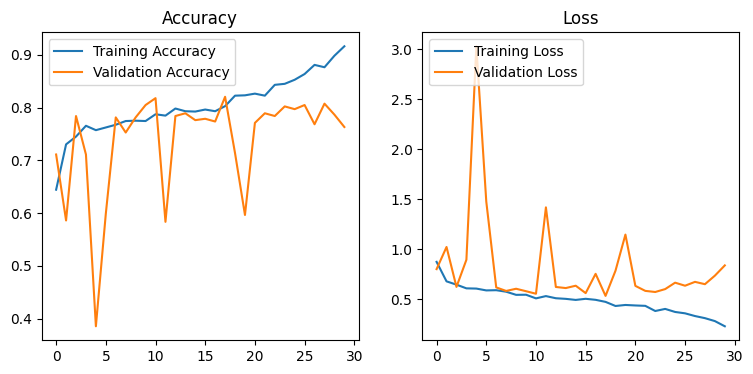

In [82]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [83]:
best_resnet18 = get_best_model(resnet18) # Testing the best VGG 19 model
test_model(best_resnet18)

Submission file created!


In [84]:
import torch
import torch.nn as nn

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        identity = self.downsample(identity)
        
        out += identity
        out = self.relu(out)
        
        return out

# Define the ResNet-50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out

In [85]:
resnet50 = ResNet50()
resnet50, train_loss, valid_loss, train_acc, valid_acc = train_model(resnet50, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["ResNet 50 Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Epoch:1 train loss: 1.0598601855729755              valid loss: 1.1631653838687472 valid accuracy: 0.2638889000647598 


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Epoch:2 train loss: 0.46906467331083196              valid loss: 0.5359745422999064 valid accuracy: 0.5925926135645972 


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch:3 train loss: 0.4545692609328973              valid loss: 0.4890933649407493 valid accuracy: 0.6574074294832017 


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch:4 train loss: 0.4728383076818366              valid loss: 1.0935535960727267 valid accuracy: 0.5092592736085256 


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch:5 train loss: 0.42615563030305664              valid loss: 0.6828565564420488 valid accuracy: 0.6111111376020644 


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Epoch:6 train loss: 0.4477896988391876              valid loss: 0.5068884856171079 valid accuracy: 0.49537038803100586 


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Epoch:7 train loss: 0.4203010428892939              valid loss: 0.49279218580987716 valid accuracy: 0.6296296583281623 


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch:8 train loss: 0.42208333117397207              valid loss: 0.6067354513539208 valid accuracy: 0.5092592736085256 


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch:9 train loss: 0.4191120364948323              valid loss: 0.6339574389987521 valid accuracy: 0.5833333565129174 


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch:10 train loss: 0.4408266771780817              valid loss: 0.46214578217930263 valid accuracy: 0.5138888988229964 


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch:11 train loss: 0.41899773125585754              valid loss: 0.5161987741788229 valid accuracy: 0.6296296384599473 


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch:12 train loss: 0.4447101950645447              valid loss: 0.45368046561876935 valid accuracy: 0.6342592802312639 


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch:13 train loss: 0.3972716641269232              valid loss: 0.45829450753000045 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Epoch:14 train loss: 0.4146120579619157              valid loss: 0.5140605403317345 valid accuracy: 0.5555555721124014 


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch:15 train loss: 0.4151602485462239              valid loss: 0.4670184850692749 valid accuracy: 0.6250000298023224 


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch:16 train loss: 0.43280107449544103              valid loss: 0.4233382311132219 valid accuracy: 0.6342592802312639 


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Epoch:17 train loss: 0.3807064545781989              valid loss: 0.454150077369478 valid accuracy: 0.6157407595051659 


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch:18 train loss: 0.37358453909033223              valid loss: 0.48606257968478733 valid accuracy: 0.6388889087571038 


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Epoch:19 train loss: 0.38472292023269755              valid loss: 0.4678526388274299 valid accuracy: 0.500000011589792 


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch:20 train loss: 0.3876190577682696              valid loss: 0.9464840822749667 valid accuracy: 0.49074075288242763 


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch:21 train loss: 0.44066649126379115              valid loss: 0.5382900900310941 valid accuracy: 0.5416666799121432 


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch:22 train loss: 0.43050780186527654              valid loss: 0.5214806563324399 valid accuracy: 0.5601852072609795 


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch:23 train loss: 0.38832742956123856              valid loss: 0.4481991363896264 valid accuracy: 0.6250000132454766 


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch:24 train loss: 0.3670175432374603              valid loss: 0.46535400218433803 valid accuracy: 0.6296296450826857 


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch:25 train loss: 0.37590659919537994              valid loss: 0.5310337543487549 valid accuracy: 0.5833333432674408 


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch:26 train loss: 0.3733500520649709              valid loss: 0.48384349544843036 valid accuracy: 0.5972222354676988 


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch:27 train loss: 0.36872656447322744              valid loss: 0.44222665164205766 valid accuracy: 0.6296296417713165 


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch:28 train loss: 0.37462671336374787              valid loss: 0.553015884425905 valid accuracy: 0.5277777943346236 


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch:29 train loss: 0.37604830531697525              valid loss: 0.5366346935431162 valid accuracy: 0.5925926069418589 


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

Epoch:30 train loss: 0.3951619526273326              valid loss: 0.48304444717036354 valid accuracy: 0.5925926168759664 


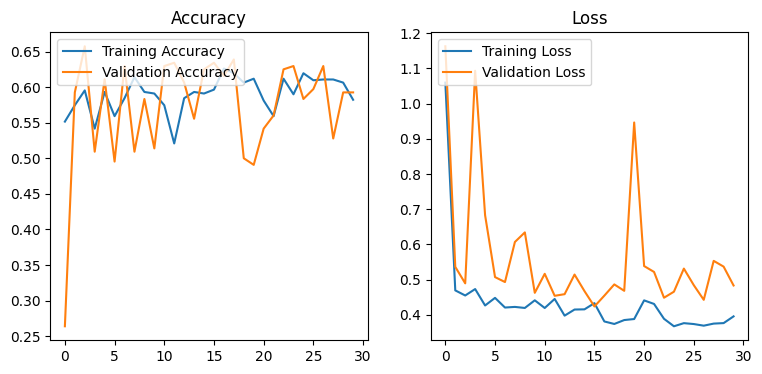

In [86]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [87]:
best_resnet50 = get_best_model(resnet50, is_SD=False) # Testing the best VGG 19 model
test_model(best_resnet50, is_SD=False)

Submission file created!


## Augmented dataset

In [89]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129,
 'ResNet18 SD': 0.8203125242143869,
 'ResNet 50 Original': 0.6574074294832017}

In [90]:
resnet50 = ResNet50() # ReInitializing the model weigths

resnet50, train_loss, valid_loss, train_acc, valid_acc = train_model(resnet50, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["ResNet 50 SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch:1 train loss: 1.269482502570519              valid loss: 1.8933056741952896 valid accuracy: 0.30989584047347307 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:2 train loss: 0.6964099939052876              valid loss: 1.4307930581271648 valid accuracy: 0.6119791809469461 


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch:3 train loss: 0.6726446518531213              valid loss: 0.9334693867713213 valid accuracy: 0.6458333600312471 


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch:4 train loss: 0.6555688899296981              valid loss: 0.7323126960545778 valid accuracy: 0.7421875242143869 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:5 train loss: 0.6294505807069631              valid loss: 1.3582468070089817 valid accuracy: 0.6458333497866988 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:6 train loss: 0.6321462310277499              valid loss: 1.4313624575734138 valid accuracy: 0.5572916818782687 


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch:7 train loss: 0.5901388221062147              valid loss: 0.6858954764902592 valid accuracy: 0.7447916883975267 


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch:8 train loss: 0.6456024522964771              valid loss: 1.4681063033640385 valid accuracy: 0.6119791846722364 


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch:9 train loss: 0.5778296232223511              valid loss: 1.4617326967418194 valid accuracy: 0.5729166828095913 


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch:10 train loss: 0.5550934071724232              valid loss: 0.7085028197616339 valid accuracy: 0.7291666902601719 


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch:11 train loss: 0.5721366231258099              valid loss: 1.3348371610045433 valid accuracy: 0.658854185603559 


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch:12 train loss: 0.5582242663090046              valid loss: 0.5568332886323333 valid accuracy: 0.7838541865348816 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:13 train loss: 0.5471995674646818              valid loss: 0.6199127677828074 valid accuracy: 0.7890625223517418 


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch:14 train loss: 0.5803924523867093              valid loss: 0.8008523434400558 valid accuracy: 0.7213541865348816 


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch:15 train loss: 0.5397331558741056              valid loss: 0.6812291536480188 valid accuracy: 0.7578125242143869 


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch:16 train loss: 0.5244020065435997              valid loss: 0.5625597462058067 valid accuracy: 0.8098958469927311 


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch:17 train loss: 0.5254346104768607              valid loss: 0.5744707155972719 valid accuracy: 0.786458358168602 


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch:18 train loss: 0.4995313605436912              valid loss: 0.6152808926999569 valid accuracy: 0.8020833525806665 


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch:19 train loss: 0.49773458655063924              valid loss: 0.8280718699097633 valid accuracy: 0.7447916883975267 


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch:20 train loss: 0.49556417786158047              valid loss: 0.5199080687016249 valid accuracy: 0.8177083544433117 


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch:21 train loss: 0.47637675106525423              valid loss: 0.8124460987746716 valid accuracy: 0.7291666846722364 


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch:22 train loss: 0.46228369520260737              valid loss: 0.5376139394938946 valid accuracy: 0.8177083544433117 


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch:23 train loss: 0.4668092459440231              valid loss: 0.533811760134995 valid accuracy: 0.8046875242143869 


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch:24 train loss: 0.4945058623185525              valid loss: 0.8490155711770058 valid accuracy: 0.6718750214204192 


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch:25 train loss: 0.4799208040420826              valid loss: 0.8209513071924448 valid accuracy: 0.7161458544433117 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:26 train loss: 0.4757251361241707              valid loss: 0.5526017555966973 valid accuracy: 0.8046875223517418 


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch:27 train loss: 0.44679321853014137              valid loss: 0.5686883190646768 valid accuracy: 0.809895858168602 


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch:28 train loss: 0.4282640436520943              valid loss: 0.6298029962927103 valid accuracy: 0.8151041865348816 


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch:29 train loss: 0.4290562233099571              valid loss: 0.552015864290297 valid accuracy: 0.8098958637565374 


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

Epoch:30 train loss: 0.40280447120849905              valid loss: 0.6782166957855225 valid accuracy: 0.7682291828095913 


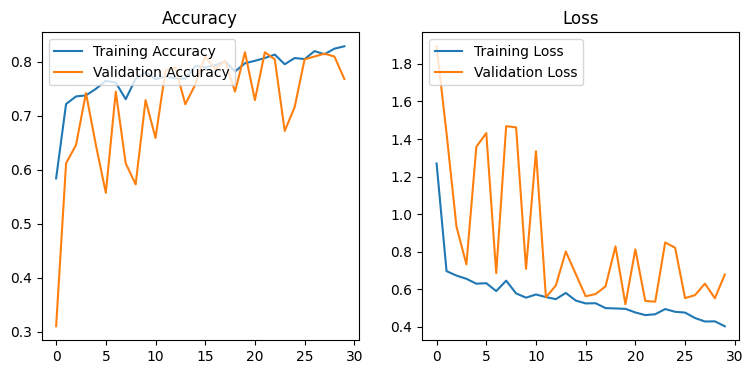

In [91]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [92]:
best_resnet = get_best_model(resnet50 ) # Testing the best VGG 19 model
test_model(best_resnet50)

Submission file created!


# Inception

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Inception module
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels[1], kernel_size=1),
            nn.Conv2d(out_channels[1], out_channels[2], kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels[3], kernel_size=1),
            nn.Conv2d(out_channels[3], out_channels[4], kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels[5], kernel_size=1)
        )
        
    def forward(self, x):
        branch1_output = self.branch1(x)
        branch2_output = self.branch2(x)
        branch3_output = self.branch3(x)
        branch4_output = self.branch4(x)
        
        output = torch.cat([branch1_output, branch2_output, branch3_output, branch4_output], dim=1)
        return output


# Define the Inception model
class InceptionModel(nn.Module):
    def __init__(self, num_classes):
        super(InceptionModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception1 = InceptionModule(64, [64, 96, 128, 16, 32, 32])
        self.inception2 = InceptionModule(256, [128, 128, 192, 32, 96, 64])
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception3 = InceptionModule(480, [192, 96, 208, 16, 48, 64])
        self.inception4 = InceptionModule(512, [160, 112, 224, 24, 64, 64])
        self.inception5 = InceptionModule(512, [128, 128, 256, 24, 64, 64])
        self.inception6 = InceptionModule(512, [112, 144, 288, 32, 64, 64])
        self.inception7 = InceptionModule(528, [256, 160, 320, 32, 128, 128])
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception8 = InceptionModule(832, [256, 160, 320, 32, 128, 128])
        self.inception9 = InceptionModule(832, [384, 192, 384, 48, 128, 128])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool2(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        x = self.maxpool3(x)
        
        x = self.inception8(x)
        x = self.inception9(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Create an instance of the InceptionModel
num_classes = 4  # Number of output classes

In [95]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129,
 'ResNet18 SD': 0.8203125242143869,
 'ResNet 50 Original': 0.6574074294832017,
 'ResNet 50 SD': 0.8177083544433117,
 'Inception Original': 0.5138889087571038}

In [96]:
inception = InceptionModel(num_classes)
inception, train_loss, valid_loss, train_acc, valid_acc = train_model(inception, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["Inception Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch:1 train loss: 5.514367396894254              valid loss: 0.7901507649156783 valid accuracy: 0.5416666766007742 


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch:2 train loss: 16.19047782138774              valid loss: 0.7125646604432 valid accuracy: 0.3194444510671828 


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Epoch:3 train loss: 0.6328771992733604              valid loss: 0.4992964002821181 valid accuracy: 0.5555555721124014 


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Epoch:4 train loss: 0.48788932750099584              valid loss: 0.49511158135202193 valid accuracy: 0.5925926168759664 


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch:5 train loss: 0.4744904958888104              valid loss: 0.5048452582624223 valid accuracy: 0.555555565489663 


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Epoch:6 train loss: 0.47465587642632034              valid loss: 0.4960271351867252 valid accuracy: 0.5833333532015482 


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch:7 train loss: 0.4693639835244731              valid loss: 0.4819702075587379 valid accuracy: 0.6064815057648553 


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Epoch:8 train loss: 0.4682189022239886              valid loss: 0.5063321424855126 valid accuracy: 0.5833333432674408 


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch:9 train loss: 0.46337583817933736              valid loss: 0.49571573072009617 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch:10 train loss: 0.46219641205511597              valid loss: 0.4909324281745487 valid accuracy: 0.6203703880310059 


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch:11 train loss: 0.4727317047746558              valid loss: 0.5010883476999071 valid accuracy: 0.5370370580090417 


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch:12 train loss: 0.4741283176760924              valid loss: 0.48903264933162266 valid accuracy: 0.5972222354676988 


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Epoch:13 train loss: 0.468652500918037              valid loss: 0.5147797664006551 valid accuracy: 0.5231481658087836 


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch:14 train loss: 0.46619806007335063              valid loss: 0.49831903643078274 valid accuracy: 0.5509259402751923 


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Epoch:15 train loss: 0.4692620352694863              valid loss: 0.4918847150272793 valid accuracy: 0.587962978416019 


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch:16 train loss: 0.4697043527113764              valid loss: 0.4693460365136464 valid accuracy: 0.6111111376020644 


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


Epoch:17 train loss: 0.4710415037054765              valid loss: 0.5029178559780121 valid accuracy: 0.625000023179584 


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch:18 train loss: 0.4615556919261029              valid loss: 0.4867820408609178 valid accuracy: 0.611111130979326 


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch:19 train loss: 0.4581978717132619              valid loss: 0.46732502347893184 valid accuracy: 0.6111111276679568 


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Epoch:20 train loss: 0.4631389218725656              valid loss: 0.4820321367846595 valid accuracy: 0.6250000165568458 


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Epoch:21 train loss: 0.46102460826698105              valid loss: 0.49367789758576286 valid accuracy: 0.6111111342906952 


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch:22 train loss: 0.4480477218565188              valid loss: 0.4674716393152873 valid accuracy: 0.6111111276679568 


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch:23 train loss: 0.464676423292411              valid loss: 0.465815265973409 valid accuracy: 0.611111130979326 


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch:24 train loss: 0.45083817408273097              valid loss: 0.4702912900182936 valid accuracy: 0.5972222420904372 


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch:25 train loss: 0.4408832819838273              valid loss: 0.4730084207322862 valid accuracy: 0.5740740829043918 


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


Epoch:26 train loss: 0.44173907018021535              valid loss: 0.5812904404269325 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Epoch:27 train loss: 0.47060609412820714              valid loss: 0.46780865722232395 valid accuracy: 0.6435185339715745 


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Epoch:28 train loss: 0.4402785544332705              valid loss: 0.46554261445999146 valid accuracy: 0.5972222288449606 


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch:29 train loss: 0.44046274141261454              valid loss: 0.47916461692916024 valid accuracy: 0.6157407561937968 


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

Epoch:30 train loss: 0.4513673782348633              valid loss: 0.4757382339901394 valid accuracy: 0.6203703880310059 


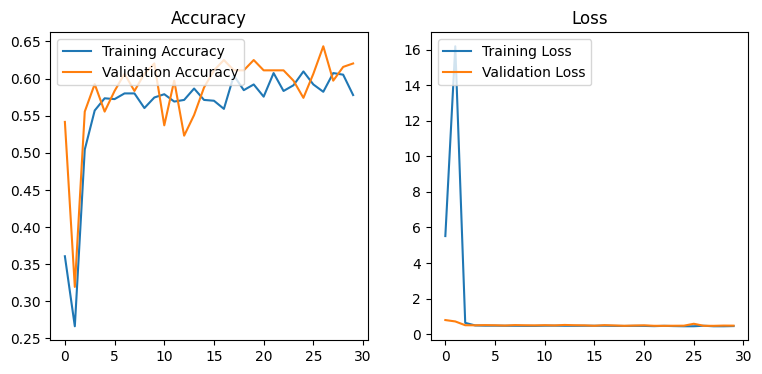

In [97]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [98]:
best_inception = get_best_model(inception, is_SD=False) # Testing the best VGG 19 model
test_model(best_inception, is_SD=False)

Submission file created!


## Augmented dataset

In [100]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129,
 'ResNet18 SD': 0.8203125242143869,
 'ResNet 50 Original': 0.6574074294832017,
 'ResNet 50 SD': 0.8177083544433117,
 'Inception Original': 0.6435185339715745}

In [101]:
inception = InceptionModel(num_classes)# ReInitializing the model weigths

inception, train_loss, valid_loss, train_acc, valid_acc = train_model(inception, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["Inception SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch:1 train loss: 1.712375310751108              valid loss: 1.47819834202528 valid accuracy: 0.2630208390764892 


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch:2 train loss: 1.3835096047474789              valid loss: 1.4878854155540466 valid accuracy: 0.26302084140479565 


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch:3 train loss: 1.3426070671815138              valid loss: 1.3851780220866203 valid accuracy: 0.36979168094694614 


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch:4 train loss: 1.213471588721642              valid loss: 1.1925063133239746 valid accuracy: 0.5078125158324838 


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch:5 train loss: 1.0884951921609731              valid loss: 1.1249380744993687 valid accuracy: 0.5286458488553762 


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch:6 train loss: 1.0752125831750723              valid loss: 1.0202470794320107 valid accuracy: 0.6067708507180214 


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch:7 train loss: 1.070734686117906              valid loss: 1.1869504898786545 valid accuracy: 0.3802083395421505 


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch:8 train loss: 1.0946098290956938              valid loss: 1.259327705949545 valid accuracy: 0.4401041753590107 


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch:9 train loss: 1.2184727522043082              valid loss: 0.9507209472358227 valid accuracy: 0.6250000167638063 


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch:10 train loss: 1.0165281956012433              valid loss: 0.8937963657081127 valid accuracy: 0.6458333460614085 


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch:11 train loss: 0.9015743860831628              valid loss: 0.9051958322525024 valid accuracy: 0.6432291902601719 


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch:12 train loss: 0.9603712210288414              valid loss: 0.8636634945869446 valid accuracy: 0.6666666865348816 


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch:13 train loss: 0.8461668830651503              valid loss: 0.8760556392371655 valid accuracy: 0.7161458479240537 


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch:14 train loss: 0.8581673906399654              valid loss: 0.8253209665417671 valid accuracy: 0.7395833544433117 


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch:15 train loss: 0.8312693137388963              valid loss: 0.8361588455736637 valid accuracy: 0.7291666865348816 


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch:16 train loss: 0.7676710912814507              valid loss: 0.6669484544545412 valid accuracy: 0.7526041865348816 


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch:17 train loss: 0.7246014297008514              valid loss: 0.76173803396523 valid accuracy: 0.7421875204890966 


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch:18 train loss: 0.7852127854640667              valid loss: 0.7070793136954308 valid accuracy: 0.7057291939854622 


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch:19 train loss: 3830599302.5680757              valid loss: 22201655936.0 valid accuracy: 0.2031250090803951 


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch:20 train loss: 665330627.8538462              valid loss: 7763637.78125 valid accuracy: 0.23177084070630372 


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch:21 train loss: 1831756.350721154              valid loss: 451514.29296875 valid accuracy: 0.2968750107102096 


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch:22 train loss: 401499.3853365385              valid loss: 279804.6044921875 valid accuracy: 0.28645834466442466 


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch:23 train loss: 280952.8984375              valid loss: 197179.0224609375 valid accuracy: 0.28125000814907253 


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch:24 train loss: 279323.9735576923              valid loss: 193534.15551757812 valid accuracy: 0.32291668234393 


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch:25 train loss: 260315.51490384617              valid loss: 364297.60693359375 valid accuracy: 0.35937500931322575 


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch:26 train loss: 193335.41370192307              valid loss: 176933.41943359375 valid accuracy: 0.34114584047347307 


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch:27 train loss: 244695.621875              valid loss: 360457.2783203125 valid accuracy: 0.2734375079162419 


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch:28 train loss: 186629.1765625              valid loss: 127577.65454101562 valid accuracy: 0.33593751303851604 


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch:29 train loss: 134502.78058894232              valid loss: 87220.16235351562 valid accuracy: 0.3255208460614085 


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

Epoch:30 train loss: 141016.1513221154              valid loss: 173895.9287109375 valid accuracy: 0.41145834419876337 


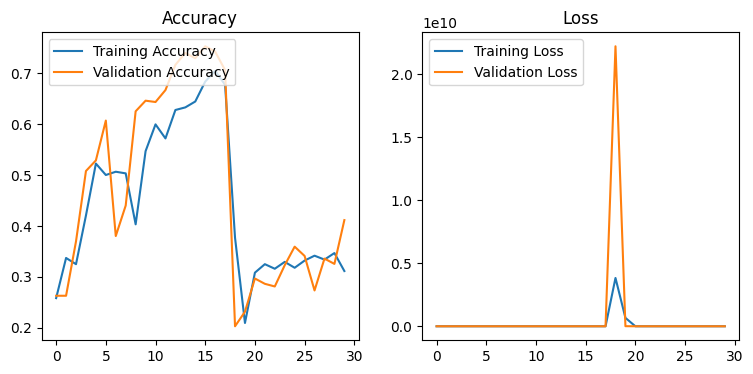

In [102]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [103]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129,
 'ResNet18 SD': 0.8203125242143869,
 'ResNet 50 Original': 0.6574074294832017,
 'ResNet 50 SD': 0.8177083544433117,
 'Inception Original': 0.6435185339715745,
 'Inception SD': 0.7526041865348816}

In [104]:
best_inception = get_best_model(inception ) # Testing the best VGG 19 model
test_model(best_inception)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Submission file created!


# VIT

In [105]:

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) 

In [107]:
vit = MyViT((3, 256, 256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=4).to(device)
vit, train_loss, valid_loss, train_acc, valid_acc = train_model(vit, train_loader,
                                    valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["VIT Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch:1 train loss: 0.6998705816896338              valid loss: 0.7252869407335917 valid accuracy: 0.41203704807493424 


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch:2 train loss: 0.6790942455592909              valid loss: 0.707258575492435 valid accuracy: 0.4907407495710585 


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


Epoch:3 train loss: 0.6633210809607255              valid loss: 0.6990339689784579 valid accuracy: 0.4907407561937968 


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch:4 train loss: 0.660893832382403              valid loss: 0.6823572648896111 valid accuracy: 0.5601851973268721 


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Epoch:5 train loss: 0.6256231547970521              valid loss: 0.6800500551859537 valid accuracy: 0.527777784400516 


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch:6 train loss: 0.604849176971536              valid loss: 0.6600306828816732 valid accuracy: 0.6157407694392734 


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


Epoch:7 train loss: 0.6101543221034502              valid loss: 0.6875420610109965 valid accuracy: 0.5555555721124014 


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Epoch:8 train loss: 0.6057766095588082              valid loss: 0.661201086309221 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Epoch:9 train loss: 0.5874551746406054              valid loss: 0.6588697897063361 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


Epoch:10 train loss: 0.582095133630853              valid loss: 0.6616901954015096 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Epoch:11 train loss: 0.577196246699283              valid loss: 0.6472580995824602 valid accuracy: 0.6203703880310059 


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch:12 train loss: 0.5821993296083651              valid loss: 0.6718185212877061 valid accuracy: 0.6064815024534861 


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch:13 train loss: 0.5937998843820471              valid loss: 0.6718847685390048 valid accuracy: 0.6064814925193787 


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Epoch:14 train loss: 0.5815151733787436              valid loss: 0.6899606585502625 valid accuracy: 0.5740740895271301 


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch:15 train loss: 0.5829590260982513              valid loss: 0.6543587545553843 valid accuracy: 0.6203703880310059 


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


Epoch:16 train loss: 0.5817169986273113              valid loss: 0.6735874381330278 valid accuracy: 0.6064815024534861 


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch:17 train loss: 0.5767584968554346              valid loss: 0.6534951859050326 valid accuracy: 0.6157407628165351 


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Epoch:18 train loss: 0.5841825737764961              valid loss: 0.6454582081900703 valid accuracy: 0.6111111276679568 


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch:19 train loss: 0.5779288411140442              valid loss: 0.6501440107822418 valid accuracy: 0.6018518706162771 


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Epoch:20 train loss: 0.5706481894380168              valid loss: 0.6338297228018442 valid accuracy: 0.6435185372829437 


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch:21 train loss: 0.5924044165172075              valid loss: 0.6363245414363013 valid accuracy: 0.6296296483940549 


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch:22 train loss: 0.5732302673553166              valid loss: 0.6450947423775991 valid accuracy: 0.6250000165568458 


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch:23 train loss: 0.5673927703970357              valid loss: 0.669534358713362 valid accuracy: 0.6018518739276462 


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Epoch:24 train loss: 0.573411300778389              valid loss: 0.6625200178888109 valid accuracy: 0.6064815123875936 


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch:25 train loss: 0.568319486944299              valid loss: 0.6526120437516106 valid accuracy: 0.6111111276679568 


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Epoch:26 train loss: 0.5686526000499725              valid loss: 0.6528956724537743 valid accuracy: 0.6157407595051659 


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch:27 train loss: 0.5699581652879715              valid loss: 0.6495579646693336 valid accuracy: 0.620370391342375 


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Epoch:28 train loss: 0.5688572871057611              valid loss: 0.6570012304517958 valid accuracy: 0.6018518639935387 


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch:29 train loss: 0.5562220372651753              valid loss: 0.6572278804249234 valid accuracy: 0.606481499142117 


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

Epoch:30 train loss: 0.561272847025018              valid loss: 0.6413409743044112 valid accuracy: 0.6157407628165351 


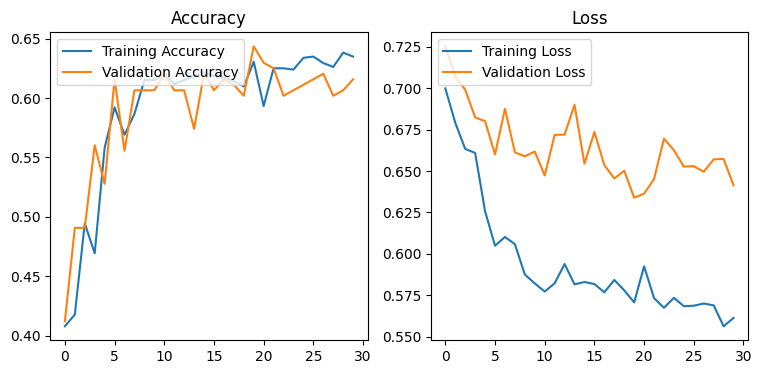

In [108]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [109]:
best_vit = get_best_model(vit, is_SD=False) # Testing the best VGG 19 model
test_model(best_vit, is_SD=False)

Submission file created!


In [110]:
accuracies

{'VGG19 Original': 0.4907407611608505,
 'Teat Clf Original': 0.6666666865348816,
 'VGG19 SD': 0.7083333507180214,
 'Teat CLF SD': 0.8359375223517418,
 'ResNet18 Original': 0.6435185405943129,
 'ResNet18 SD': 0.8203125242143869,
 'ResNet 50 Original': 0.6574074294832017,
 'ResNet 50 SD': 0.8177083544433117,
 'Inception Original': 0.6435185339715745,
 'Inception SD': 0.7526041865348816,
 'VIT Original': 0.6435185372829437}

## Augmented dataset

In [111]:
vit = MyViT((3, 256, 256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=4).to(device) # ReInitializing the model weigths

vit, train_loss, valid_loss, train_acc, valid_acc = train_model(vit, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["VIT SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch:1 train loss: 1.4184197279123159              valid loss: 1.4737724587321281 valid accuracy: 0.26302084047347307 


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch:2 train loss: 1.4101681012373704              valid loss: 1.4689546525478363 valid accuracy: 0.2526041781529784 


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch:3 train loss: 1.404129642706651              valid loss: 1.4703037217259407 valid accuracy: 0.25520834256894886 


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch:4 train loss: 1.399478184259855              valid loss: 1.4442332610487938 valid accuracy: 0.3333333458285779 


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch:5 train loss: 1.3219296271984393              valid loss: 1.33383047580719 valid accuracy: 0.5052083488553762 


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch:6 train loss: 1.277618120266841              valid loss: 1.3971095830202103 valid accuracy: 0.45572917233221233 


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch:7 train loss: 1.2688606170507577              valid loss: 1.308601826429367 valid accuracy: 0.5260416846722364 


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch:8 train loss: 1.2525173388994657              valid loss: 1.2870907634496689 valid accuracy: 0.5572916816454381 


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch:9 train loss: 1.2337759293042696              valid loss: 1.298817127943039 valid accuracy: 0.5494791800156236 


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch:10 train loss: 1.211003039433406              valid loss: 1.2710232473909855 valid accuracy: 0.546875013038516 


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch:11 train loss: 1.2038936358231764              valid loss: 1.235885914415121 valid accuracy: 0.5937500223517418 


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch:12 train loss: 1.2045613701526936              valid loss: 1.2557382360100746 valid accuracy: 0.5572916837409139 


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch:13 train loss: 1.183537848179157              valid loss: 1.2436655312776566 valid accuracy: 0.5807291800156236 


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch:14 train loss: 1.1738032735311068              valid loss: 1.2209706380963326 valid accuracy: 0.5937500167638063 


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch:15 train loss: 1.19154458962954              valid loss: 1.231754306703806 valid accuracy: 0.5859375242143869 


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch:16 train loss: 1.1598224117205693              valid loss: 1.2644188180565834 valid accuracy: 0.5572916781529784 


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch:17 train loss: 1.133638935822707              valid loss: 1.1662095449864864 valid accuracy: 0.6614583544433117 


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch:18 train loss: 1.1226705707036533              valid loss: 1.2146238572895527 valid accuracy: 0.6067708479240537 


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch:19 train loss: 1.1141151721660907              valid loss: 1.1376012414693832 valid accuracy: 0.6901041902601719 


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch:20 train loss: 1.090325874548692              valid loss: 1.1490797810256481 valid accuracy: 0.6848958525806665 


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch:21 train loss: 1.0901637013141925              valid loss: 1.1153063103556633 valid accuracy: 0.7109375223517418 


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch:22 train loss: 1.071430504322052              valid loss: 1.1133673191070557 valid accuracy: 0.7031250223517418 


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch:23 train loss: 1.0796865426577054              valid loss: 1.1216603443026543 valid accuracy: 0.6979166865348816 


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch:24 train loss: 1.0970880545102633              valid loss: 1.1097977235913277 valid accuracy: 0.7135416865348816 


100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch:25 train loss: 1.063054477251493              valid loss: 1.1188278123736382 valid accuracy: 0.7005208507180214 


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch:26 train loss: 1.0605474692124588              valid loss: 1.0975777618587017 valid accuracy: 0.7109375186264515 


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch:27 train loss: 1.0580493395145123              valid loss: 1.1129894703626633 valid accuracy: 0.7109375186264515 


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch:28 train loss: 1.0552191119927627              valid loss: 1.1138541102409363 valid accuracy: 0.7135416846722364 


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch:29 train loss: 1.0803791798078097              valid loss: 1.1245731115341187 valid accuracy: 0.6927083544433117 


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]

Epoch:30 train loss: 1.0597505431908827              valid loss: 1.1085853092372417 valid accuracy: 0.7109375223517418 


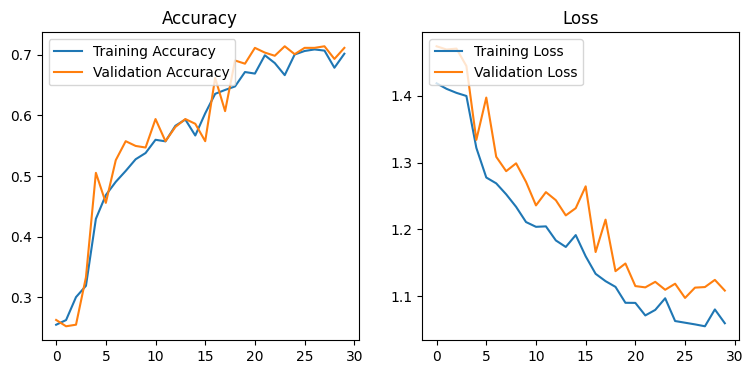

In [112]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [113]:
best_vit = get_best_model(vit ) # Testing the best VGG 19 model
test_model(best_vit)

Submission file created!


# Google Net

In [12]:
from torchvision.models import googlenet
googlenet = googlenet(pretrained=False)
num_features = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_features, 4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [13]:
def train_gnet(model, traindl, testdl, loss_fn, epochs, learning_rate, is_SD=True):
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    train_acc = []

    opt = optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = loss_fn
    model = model.to(device)
    aux_criterion = nn.CrossEntropyLoss()
    model_name = model.__class__.__name__
    if is_SD:
      trainSteps = int(len(train_ds_SD)/batch_size)
      validSteps = int(len(valid_ds_SD)/batch_size)
      model_name += "_SD"
    else:
      trainSteps = int(len(train_ds)/batch_size)
      validSteps = int(len(valid_ds)/batch_size)
      model_name += "_Org"
    best_val_loss = float('inf')

    try:
        for epoch in range(1, epochs+1):
            # Training loop
            model.train(True)
            correct = 0
            totalTrainLoss ,totalTestLoss, totalTrainAcc, totalTestAcc = 0, 0, 0, 0

            for X, y in tqdm(traindl):  
                X, y = X.to(device), y.to(device) 
                opt.zero_grad()
                yhat, aux_logits1, aux_logits2 = model(X) 
                aux_loss1 = aux_criterion(aux_logits1, y)
                aux_loss2 = aux_criterion(aux_logits2, y)
                loss = loss_fn(yhat, y)
                loss = loss + 0.3 * aux_loss1 + 0.3 * aux_loss2
                acc = (torch.argmax(yhat, axis=1) == y).sum()/batch_size
                totalTrainAcc += acc.item()
                totalTrainLoss += loss.item()
                loss.backward()
                opt.step() 
            avg_acc = totalTrainAcc / trainSteps
            avg_loss = (totalTrainLoss/trainSteps)
            train_acc.append(avg_acc)
            train_loss.append(avg_loss)

            # Evaluation step
            model.train(False)

            with torch.no_grad():
                for X, y in tqdm(testdl): 
                    X, y = X.to(device), y.to(device) 
                    yhat = model(X) 
                    loss = loss_fn(yhat, y)
                    acc = (y == torch.argmax(yhat, axis=1)).sum()/batch_size
                    totalTestAcc += acc.item()
                    totalTestLoss += loss.item()
                avg_acc = (totalTestAcc/validSteps)
                avg_loss = (totalTestLoss/validSteps)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    torch.save(model, f"{model_name}_{round(avg_acc, 5)}.pth")
                valid_loss.append(avg_loss)
                valid_acc.append(avg_acc)
                print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
             valid loss: {avg_loss} valid accuracy: {avg_acc} ")

    except KeyboardInterrupt:
        return model, train_loss, valid_loss, train_acc, valid_acc
    return model, train_loss, valid_loss, train_acc, valid_acc

In [15]:
googlenet, train_loss, valid_loss, train_acc, valid_acc = train_gnet(googlenet, train_loader,
                            valid_loader, epochs=num_epochs, loss_fn = F_loss, learning_rate=lr, is_SD=False)
accuracies["Google Net Original"] = max(valid_acc)

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch:1 train loss: 1.025670355872104              valid loss: 0.833010627163781 valid accuracy: 0.5324074195490943 


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch:2 train loss: 1.0026848739699314              valid loss: 0.4582658078935411 valid accuracy: 0.6111111342906952 


100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Epoch:3 train loss: 0.9404179061713972              valid loss: 0.43518082135253483 valid accuracy: 0.6157407661279043 


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch:4 train loss: 0.9276309452558819              valid loss: 0.4464765124850803 valid accuracy: 0.569444457689921 


100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Epoch:5 train loss: 0.9688761516621238              valid loss: 0.46553507778379655 valid accuracy: 0.6296296483940549 


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch:6 train loss: 0.9047669956558629              valid loss: 0.4679991453886032 valid accuracy: 0.625000019868215 


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Epoch:7 train loss: 0.8671516493747109              valid loss: 0.47184181544515824 valid accuracy: 0.6527777943346236 


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Epoch:8 train loss: 0.8814043779122201              valid loss: 0.4949135349856483 valid accuracy: 0.6481481658087836 


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Epoch:9 train loss: 0.847982456809596              valid loss: 0.44550349977281356 valid accuracy: 0.6111111342906952 


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Epoch:10 train loss: 0.8443075512584887              valid loss: 0.6864588724242316 valid accuracy: 0.4907407545381122 


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch:11 train loss: 0.8243319454946016              valid loss: 0.441513255238533 valid accuracy: 0.625000019868215 


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch:12 train loss: 0.8218263136713129              valid loss: 0.4801124499903785 valid accuracy: 0.5787037213643392 


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch:13 train loss: 0.8342196549239912              valid loss: 0.6901939312616984 valid accuracy: 0.5370370497306188 


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


Epoch:14 train loss: 0.8328510130706587              valid loss: 0.46293503708309597 valid accuracy: 0.611111130979326 


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch:15 train loss: 0.7796006618361724              valid loss: 0.5462588982449638 valid accuracy: 0.6018518606821696 


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


Epoch:16 train loss: 0.7862832624661295              valid loss: 0.4211226635509067 valid accuracy: 0.6481481691201528 


100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Epoch:17 train loss: 0.8011507658581984              valid loss: 0.44795066283808815 valid accuracy: 0.6388889021343656 


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch:18 train loss: 0.7468771809025815              valid loss: 0.7013511392805312 valid accuracy: 0.5231481591860453 


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch:19 train loss: 0.7525305261737422              valid loss: 0.40087082650926376 valid accuracy: 0.6481481591860453 


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch:20 train loss: 0.717975640767499              valid loss: 0.410139756070243 valid accuracy: 0.6342592868540022 


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch:21 train loss: 0.7745887441070456              valid loss: 0.4786892185608546 valid accuracy: 0.638888912068473 


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Epoch:22 train loss: 0.7436492584253612              valid loss: 0.4628218859434128 valid accuracy: 0.5879629916614957 


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch:23 train loss: 0.6941969229986793              valid loss: 0.4572704467508528 valid accuracy: 0.6296296616395315 


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch:24 train loss: 0.6785152860377964              valid loss: 0.4331688682238261 valid accuracy: 0.574074086215761 


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch:25 train loss: 0.6488526620362934              valid loss: 0.38073096175988513 valid accuracy: 0.6111111243565878 


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch:26 train loss: 0.6682811606871454              valid loss: 0.4231886151764128 valid accuracy: 0.6527777910232544 


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch:27 train loss: 0.6408770233392715              valid loss: 0.47027072310447693 valid accuracy: 0.6296296550167931 


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


Epoch:28 train loss: 0.6402120009848946              valid loss: 0.4129091501235962 valid accuracy: 0.6527777910232544 


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Epoch:29 train loss: 0.6092934302593532              valid loss: 0.42228949401113725 valid accuracy: 0.6481481658087836 


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]

Epoch:30 train loss: 0.6313325182387703              valid loss: 0.4175978849331538 valid accuracy: 0.6481481790542603 


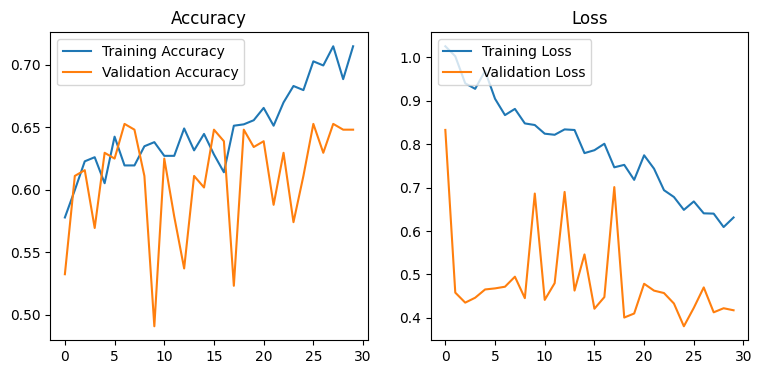

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [17]:
best_googlenet = get_best_model(googlenet, is_SD=False ) # Testing the best VGG 19 model
test_model(best_googlenet, is_SD=False)

Submission file created!


## Augmented dataset

In [18]:
googlenet, train_loss, valid_loss, train_acc, valid_acc = train_gnet(googlenet, train_loader_SD,
                                    valid_loader_SD, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["GoogleNet SD"] = max(valid_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch:1 train loss: 1.095143078840696              valid loss: 0.5418389476835728 valid accuracy: 0.8072916902601719 


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch:2 train loss: 0.8308220881682176              valid loss: 0.5688779093325138 valid accuracy: 0.8020833525806665 


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch:3 train loss: 0.7956976973093473              valid loss: 0.5461032371968031 valid accuracy: 0.7942708563059568 


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch:4 train loss: 0.7917844611864824              valid loss: 0.6090481504797935 valid accuracy: 0.786458358168602 


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch:5 train loss: 0.7425060134667617              valid loss: 0.504782279022038 valid accuracy: 0.8072916883975267 


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch:6 train loss: 0.6976170998353225              valid loss: 0.49680337868630886 valid accuracy: 0.7890625204890966 


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch:7 train loss: 0.7306069186100593              valid loss: 0.48680209554731846 valid accuracy: 0.8125000260770321 


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch:8 train loss: 0.7042506736058455              valid loss: 0.5426239632070065 valid accuracy: 0.8046875204890966 


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch:9 train loss: 0.6652051627635955              valid loss: 0.5668381080031395 valid accuracy: 0.7682291865348816 


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch:10 train loss: 0.6798957228660584              valid loss: 0.6215754691511393 valid accuracy: 0.7656250204890966 


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch:11 train loss: 0.6352778595227462              valid loss: 0.5220591444522142 valid accuracy: 0.8151041883975267 


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch:12 train loss: 0.6220527323392722              valid loss: 0.5331418961286545 valid accuracy: 0.8046875223517418 


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch:13 train loss: 0.6367321631083122              valid loss: 0.48341521993279457 valid accuracy: 0.8281250204890966 


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch:14 train loss: 0.6067946628882335              valid loss: 0.5089209182187915 valid accuracy: 0.825520845130086 


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch:15 train loss: 0.5615499585866928              valid loss: 0.5786179341375828 valid accuracy: 0.8098958525806665 


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch:16 train loss: 0.5879273089078757              valid loss: 0.5028549479320645 valid accuracy: 0.830729185603559 


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch:17 train loss: 0.5506798576850157              valid loss: 0.6656806282699108 valid accuracy: 0.7864583544433117 


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch:18 train loss: 0.5568189380260614              valid loss: 0.501477837562561 valid accuracy: 0.8125000111758709 


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch:19 train loss: 0.5069357104026354              valid loss: 0.5286945295520127 valid accuracy: 0.8385416939854622 


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch:20 train loss: 0.4607511103153229              valid loss: 0.4801510185934603 valid accuracy: 0.8515625186264515 


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch:21 train loss: 0.44786227230842296              valid loss: 0.6260888781398535 valid accuracy: 0.8203125204890966 


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch:22 train loss: 0.5067349378879253              valid loss: 0.6319313365966082 valid accuracy: 0.7786458600312471 


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch:23 train loss: 0.45290433970781474              valid loss: 0.6602312345057726 valid accuracy: 0.7942708600312471 


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch:24 train loss: 0.4012538329913066              valid loss: 0.491801212541759 valid accuracy: 0.8359375204890966 


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch:25 train loss: 0.37972763432906226              valid loss: 0.6580585660412908 valid accuracy: 0.8255208618938923 


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch:26 train loss: 0.3859672674765954              valid loss: 0.609096422791481 valid accuracy: 0.8229166865348816 


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch:27 train loss: 0.3433814844259849              valid loss: 0.7800272181630135 valid accuracy: 0.7812500186264515 


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch:28 train loss: 0.35006797302227755              valid loss: 0.620312787592411 valid accuracy: 0.8385416828095913 


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch:29 train loss: 0.358522296582277              valid loss: 0.6049193507060409 valid accuracy: 0.8333333507180214 


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]

Epoch:30 train loss: 0.3133926980770551              valid loss: 0.5946208983659744 valid accuracy: 0.8203125242143869 


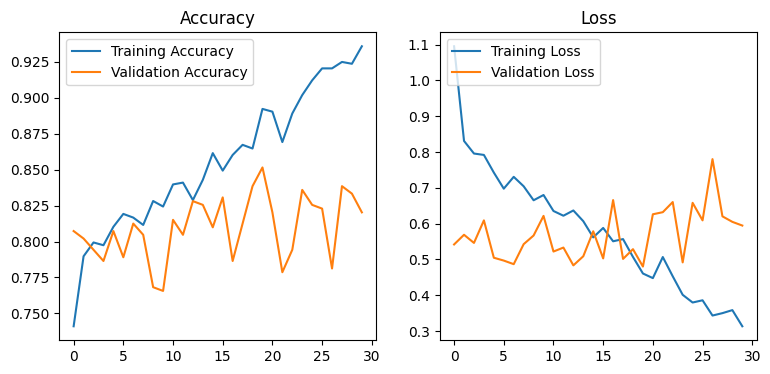

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(9, 4))

axis[1].plot(train_loss, label='Training Loss')
axis[1].plot(valid_loss, label='Validation Loss')
axis[1].set_title("Loss")
axis[1].legend(loc='upper left')


axis[0].plot(train_acc, label='Training Accuracy')
axis[0].plot(valid_acc, label='Validation Accuracy')
axis[0].set_title("Accuracy")
axis[0].legend(loc='upper left')

In [20]:
best_googlenet = get_best_model(googlenet ) # Testing the best VGG 19 model
test_model(best_googlenet)

Submission file created!


# Model Comparisons sorted according to validation accuracy

In [31]:
pd.DataFrame(accuracies.items(), columns=['Model', "Valid Accuracy"]).sort_values("Valid Accuracy", ascending=False)

,Model,Valid Accuracy
13,GoogleNet SD,0.851563
3,Teat CLF SD,0.835938
5,ResNet18 SD,0.820313
7,ResNet 50 SD,0.817708
9,Inception SD,0.752604
2,VGG19 SD,0.708333
11,VIT SD,0.708333
1,Teat Clf Original,0.666667
6,ResNet 50 Original,0.657407
12,Google Net Original,0.652778


# Paper link
https://www.researchgate.net/publication/370729404_Cow_teat_data_augmentation_using_Stable_Diffusion